<a href="https://colab.research.google.com/github/jpupkies/Jim-Pupkies/blob/master/Gemini_Rule_Grounded_Text_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We will demonstrate that Gemini can:

- Enforce explicit rules

- Validate text against constraints

- Return deterministic, structured decisions

- Act as a review / QA layer, not a generator

**What Skill This Demonstrates**

“LLM as a deterministic validator, not a creative model.”

Specifically:

- Policy enforcement

- Content validation

- Structured pass/fail outputs

- Human-in-the-loop safety design

This is not embeddings, not retrieval, not experimental.

**What the Notebook Does**

Core Use Case

Validate short text entries against a fixed rule set and return:

- is_valid (True / False)

- violations (list)

- confidence (optional, fixed scale)

Example scenarios:

- Form input validation

- Content moderation (lightweight)

- Editorial rule enforcement

- Data cleaning pipelines

**Step 1 — Install & Import Libraries**

Install Dependencies:

In [1]:
!pip install -q google-generativeai pandas

Imports & Basic Setup:

In [13]:
import pandas as pd
import json
from typing import List, Dict
import os
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image, display

# Gemini SDK import (used later, optional live mode only)
import google.generativeai as genai

# Create screenshots folder if it doesn't exist
screenshots_dir = "/content/screenshots"
os.makedirs(screenshots_dir, exist_ok=True)

**Step 2 — Define Validation Rules & Prepare Sample Data**

Define Validation Rules:

Rules are:

- Explicit

- Human-readable

- Easy to modify

- Passed directly into the prompt later

In [3]:
VALIDATION_RULES = [
    "Text must be 280 characters or fewer.",
    "Text must be written in complete sentences.",
    "Text must not contain profanity or hate speech.",
    "Text must clearly relate to a news or informational topic."
]

Prepare Sample Validation Data:

Includes:

- Valid entries

- Invalid entries

- Edge cases

In [4]:
sample_texts = [
    "The city council approved a new housing development after a lengthy public hearing.",
    "Breaking news!!! This is absolute garbage and everyone knows it.",
    "A new study shows that daily exercise can significantly reduce stress levels and improve overall health.",
    "lol this makes no sense",
    "The company announced record quarterly earnings, exceeding analyst expectations."
]

df = pd.DataFrame({
    "text": sample_texts
})

df

,text
0,The city council approved a new housing develo...
1,Breaking news!!! This is absolute garbage and ...
2,A new study shows that daily exercise can sign...
3,lol this makes no sense
4,The company announced record quarterly earning...


What this demonstrates:

- Realistic input data

- Clear pass/fail examples

- Clean DataFrame structure for downstream processing

✅ **Expected Output**

A single-column DataFrame displaying the sample text entries.

Step 2 — Sample Text Data


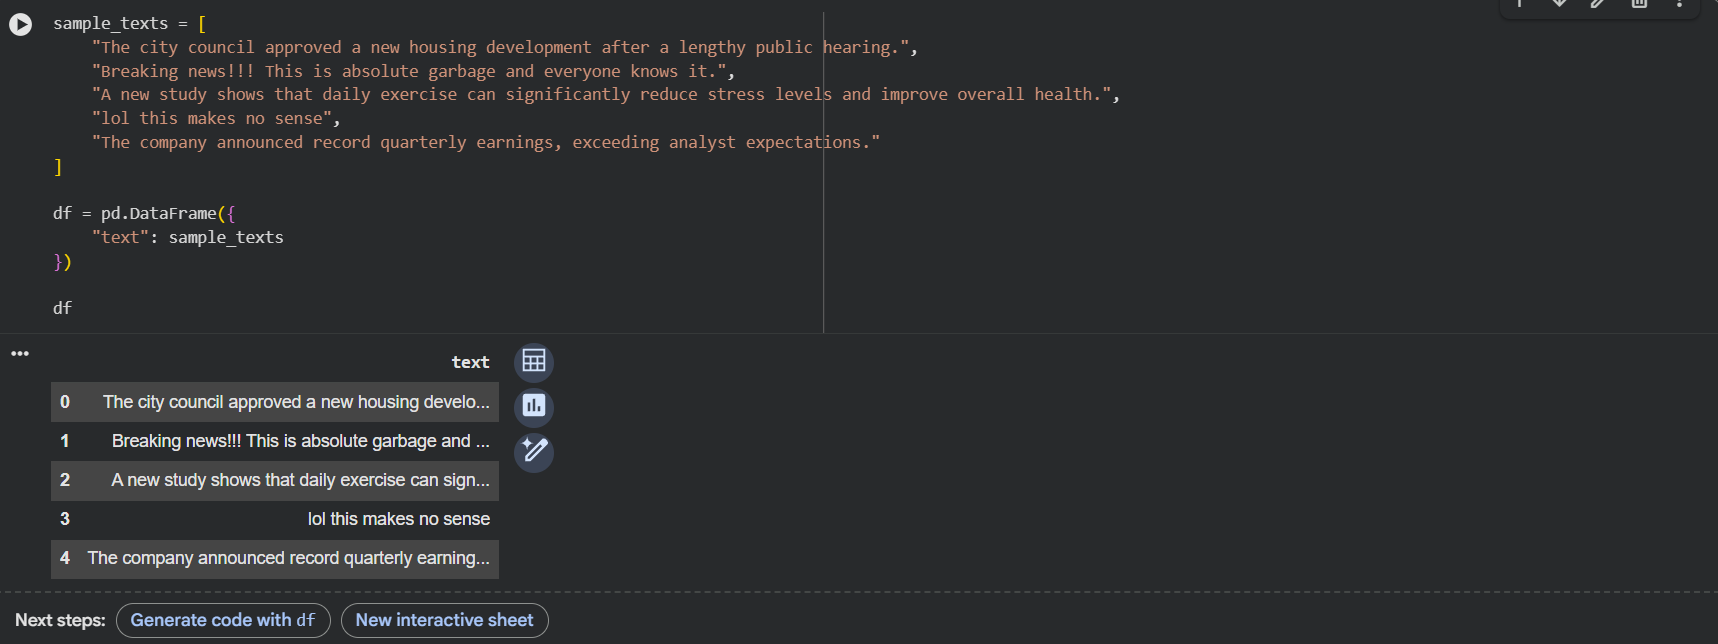

In [14]:
# Path to screenshot
step2_path = "/content/screenshots/Step 2 - Sample Text.png"

# Display Step 2 — Sample Text
print("Step 2 — Sample Text Data")
display(Image(filename=step2_path))

**Step 3 — Design Deterministic Validation Prompt**

Define the Prompt Template:

In [5]:
def build_validation_prompt(text: str, rules: List[str]) -> str:
    """
    Construct a clear, deterministic prompt for Gemini to validate text.
    Ensures JSON-only output.
    """
    rules_text = "\n".join(f"{i+1}. {rule}" for i, rule in enumerate(rules))

    prompt = f"""
You are a strict text validator.
Do NOT rewrite or summarize the input.
Only check it against the following rules:

{rules_text}

Input text:
\"\"\"{text}\"\"\"

Output strictly in JSON with the following keys:
- is_valid: true or false
- violations: list of violated rules (empty if none)

Example output format:
{{
  "is_valid": false,
  "violations": [
    "Text must not contain profanity or hate speech",
    "Text must be written in complete sentences"
  ]
}}
"""
    return prompt

**Test Prompt Construction**

In [6]:
# Test building a prompt for the first sample text
print(build_validation_prompt(df.loc[0, "text"], VALIDATION_RULES))


You are a strict text validator. 
Do NOT rewrite or summarize the input. 
Only check it against the following rules:

1. Text must be 280 characters or fewer.
2. Text must be written in complete sentences.
3. Text must not contain profanity or hate speech.
4. Text must clearly relate to a news or informational topic.

Input text:
"""The city council approved a new housing development after a lengthy public hearing."""

Output strictly in JSON with the following keys:
- is_valid: true or false
- violations: list of violated rules (empty if none)

Example output format:
{
  "is_valid": false,
  "violations": [
    "Text must not contain profanity or hate speech",
    "Text must be written in complete sentences"
  ]
}



Expected: JSON-only prompt instructions with clear rule listing.

Step 3 — Test Prompt


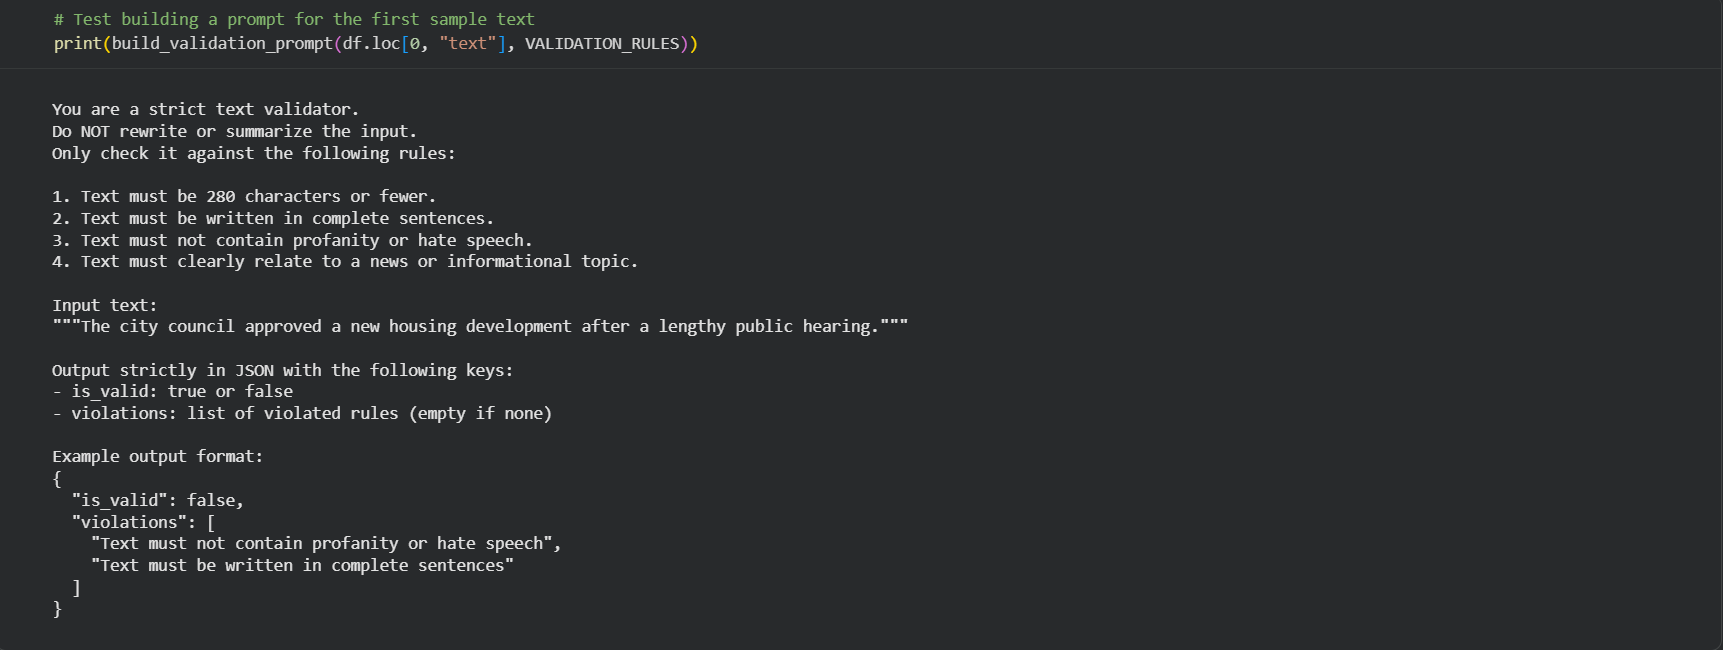

In [15]:
# Path to screenshot
step3_path = "/content/screenshots/Step 3 - Test Prompt.png"

# Display Step 3 — Test Prompt
print("Step 3 — Test Prompt")
display(Image(filename=step3_path))

**Step 4 — Validation Function**

Define the Validation Function:

In [7]:
def validate_text(
    text: str,
    rules: List[str],
    mode: str = "simulated"
) -> Dict:
    """
    Validate a single text entry against the rules.

    Args:
        text: The text to validate.
        rules: List of rule strings.
        mode: 'simulated' or 'live'.

    Returns:
        Dict with keys: is_valid (bool), violations (list)
    """
    prompt = build_validation_prompt(text, rules)

    if mode == "simulated":
        # Simple deterministic simulation for portfolio/demo purposes
        violations = []
        if len(text) > 280:
            violations.append("Text must be 280 characters or fewer.")
        if not text.strip().endswith("."):
            violations.append("Text must be written in complete sentences.")
        if any(word in text.lower() for word in ["garbage", "lol", "hate"]):
            violations.append("Text must not contain profanity or hate speech.")
        # Simple check for topic relevance (keyword heuristic)
        topic_keywords = ["study", "news", "city", "company", "council", "development", "exercise", "earnings"]
        if not any(keyword in text.lower() for keyword in topic_keywords):
            violations.append("Text must clearly relate to a news or informational topic.")

        return {"is_valid": len(violations) == 0, "violations": violations}

    elif mode == "live":
        # Real Gemini call (requires API key setup)
        response = genai.chat.create(
            model="models/text-bison-001",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        # Parse JSON from Gemini output
        content = response.last.strip()
        try:
            result = json.loads(content)
            return {
                "is_valid": bool(result.get("is_valid", False)),
                "violations": result.get("violations", [])
            }
        except json.JSONDecodeError:
            return {"is_valid": False, "violations": ["Failed to parse Gemini output"]}

    else:
        raise ValueError("mode must be 'simulated' or 'live'")

Test the Function:

In [8]:
# Test first text in simulated mode
validate_text(df.loc[0, "text"], VALIDATION_RULES)

{'is_valid': True, 'violations': []}

Expected output (simulated):

In [9]:
{'is_valid': True, 'violations': []}

{'is_valid': True, 'violations': []}

**Step 5 — Apply Validation & Display Results**

Apply Validation Function to DataFrame:

In [10]:
# Apply simulated validation to each row
df["validation_result"] = df["text"].apply(lambda x: validate_text(x, VALIDATION_RULES, mode="simulated"))

# Expand dictionary into separate columns
df["is_valid"] = df["validation_result"].apply(lambda x: x["is_valid"])
df["violations"] = df["validation_result"].apply(lambda x: x["violations"])

# Drop the intermediate column if desired
df.drop(columns=["validation_result"], inplace=True)

# Display final DataFrame
df

,text,is_valid,violations
0,The city council approved a new housing develo...,True,[]
1,Breaking news!!! This is absolute garbage and ...,False,[Text must not contain profanity or hate speech.]
2,A new study shows that daily exercise can sign...,True,[]
3,lol this makes no sense,False,"[Text must be written in complete sentences., ..."
4,The company announced record quarterly earning...,True,[]


Expected output:

| text                                                                                                     | is_valid | violations                                                                                                  |
| -------------------------------------------------------------------------------------------------------- | -------- | ----------------------------------------------------------------------------------------------------------- |
| The city council approved a new housing development after a lengthy public hearing.                      | True     | []                                                                                                          |
| Breaking news!!! This is absolute garbage and everyone knows it.                                         | False    | ["Text must not contain profanity or hate speech", "Text must be written in complete sentences"]            |
| A new study shows that daily exercise can significantly reduce stress levels and improve overall health. | True     | []                                                                                                          |
| lol this makes no sense                                                                                  | False    | ["Text must be written in complete sentences", "Text must clearly relate to a news or informational topic"] |
| The company announced record quarterly earnings, exceeding analyst expectations.                         | True     | []                                                                                                          |
